# Project 1. Flowers images recognition
**Bartosz Stoń & Dominik Raska**

Machine Learning lectured by Pétia Georgieva - University of Aveiro - April 13, 2020

Dataset: Alexander Mamaev. Flowers Recognition V2. https://www.kaggle.com/alxmamaev/flowers-recognition

In [ ]:
import os
from tqdm.notebook import tqdm
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import seaborn as sn
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [2]:
import tensorflow as tf
#tf.test.is_gpu_available() # True/False
tf.config.list_physical_devices('GPU')
# Or only check for gpu's with cuda support
tf.test.is_gpu_available(cuda_only=True) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Data Loading

In [3]:
# Base directory to folder with flowers
base_dir =  r'\Users\fuj\Desktop\_vsb\Semestr 8 - Aveiro\Machine learning\PROJEKT1\flowersNEW'

# Directions for each species
daisy_dir = os.path.join(base_dir, 'daisy')
dandelion_dir = os.path.join(base_dir, 'dandelion')
rose_dir = os.path.join(base_dir, 'rose')
sunflower_dir = os.path.join(base_dir, 'sunflower')
tulip_dir = os.path.join(base_dir, 'tulip')

In [4]:
def loadImages(species, species_dir):
    """
    for each example add image array (size, size, 3) to features (X) and species name to labels (Y)
    """
    for img in os.listdir(species_dir):
        label = species
        path = os.path.join(species_dir, img) 
        img = cv2.imread(path, cv2.IMREAD_COLOR) #Loads a color image. Any transparency of image will be neglected.
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X1.append(np.array(img))
        Y1.append(str(label))
        
    print(species + " dataset size: " + str(len(os.listdir(species_dir))))

In [5]:
IMG_SIZE = 80 #the side length of the square image
X1 = [] #farures
Y1 = [] #labels

loadImages('daisy', daisy_dir)
loadImages('dandelion', dandelion_dir)
loadImages('rose', rose_dir)
loadImages('sunflower', sunflower_dir)
loadImages('tulip', tulip_dir)

daisy dataset size: 747
dandelion dataset size: 1033
rose dataset size: 763
sunflower dataset size: 728
tulip dataset size: 942


In [6]:
print(np.shape(X1))
print(np.shape(Y1))

(4213, 80, 80, 3)
(4213,)


## Ploting subset of data

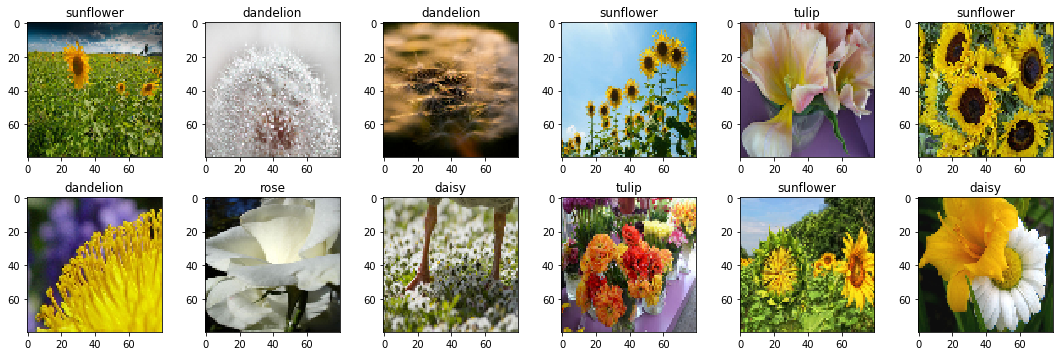

In [7]:
fig, ax = plt.subplots(2, 6)
fig.set_size_inches(15, 5)

for i in range(2):
    for j in range (6):
        rand = random.randint(0,len(Y1))
        floverBGR = X1[rand] #image loaded in BGR
        floverRGB = cv2.cvtColor(floverBGR, cv2.COLOR_BGR2RGB) #for proper color space in imshow change temporary to RGB
        ax[i,j].imshow(floverRGB)
        #ax[i,j].imshow(floverBGR)
        ax[i,j].set_title(str(Y1[rand]))
        
plt.tight_layout()

## Data preparation

In [8]:
X = np.array(X1) # list to array
X = X/255.0 # rescale RGB images
le = LabelEncoder()
Y = le.fit_transform(Y1) # numbers instead of names of species

print(np.shape(X))
print(np.shape(Y))

(4213, 80, 80, 3)
(4213,)


In [9]:
X = X.reshape(len(X), IMG_SIZE*IMG_SIZE*3) # flatten image
Y = to_categorical(Y, max(Y)+1) # One Hot Encoding

print(np.shape(X))
print(np.shape(Y))

(4213, 19200)
(4213, 5)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_test))

(3370, 19200)
(843, 19200)
(3370, 5)
(843, 5)


## K-fold Cross Validation

In [11]:
def k_fold_split_ranges(ranges, num):
    """
    determine k-fold ranges
    """
    avg = len(ranges) / float(num)
    out = []
    last = 0.0
    while last < len(ranges):
        out.append(ranges[int(last):int(last + avg)])
        last += avg
    return out

In [12]:
def k_fold_validation(X, Y, model_no, k, alfa, Lambda, epochs, batch_size):
    """
    train and validate model for each k-fold; print and plot all results; return final averaged result
    """
    # select model to use - mapping to function with correct model
    dispatcher={'model_1':model_1, 'model_2':model_2, 'model_3':model_3,
               'model_1x':model_1x, 'model_2x':model_2x, 'model_3x':model_3x}
    try:
        createModel=dispatcher[model_no]
    except KeyError:
        raise ValueError('invalid input')

    print('[INFO] Performing ' + str(k) + '-fold validation...')
    
    samples = np.shape(X)[0]  # Total size of the data set
    folds = k_fold_split_ranges(range(0, samples), k) # Split data into k folds (Cross-validation sets)
    
    # lists to collect metrics for every kfold
    fold_acc=[]
    fold_loss=[]
    
    # plot loss and accuracy for training and validation data
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    ax[0].set_title('Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylim(0,1)

    for kfold in range(0, k): # Iterate through each fold
        
        print('------------------------------------------------------------------------')
        print('[INFO] Training for fold no ' + str(kfold))
        
        start = folds[kfold][0] # first index of the fold
        end = folds[kfold][np.size(folds[kfold])-1]  # last index of the fold             
        x_tr = np.concatenate((X[:start], X[end:])) # Obtain training set by omitting current fold   
        y_tr = np.concatenate((Y[:start], Y[end:]))
        x_val = X[start:end] # obtain validation set
        y_val = Y[start:end]
        
        model = createModel(x_tr, y_tr, alfa, Lambda) # create the chosen model
        history = model.fit(x_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val)) # Train the model # verbose - method of progress printing
        (loss, accuracy) = model.evaluate(x_val, y_val, verbose=0) # Get evaluation for current fold
        
        # add loss and accuracy value to table with values for other kfolds
        fold_acc.append(accuracy * 100)
        fold_loss.append(loss)
        
        # add loss and accuracy lines to plot
        ax[0].plot(history.history['loss'], 'b')
        ax[0].plot(history.history['val_loss'], 'r')
        ax[1].plot(history.history['accuracy'], 'b')
        ax[1].plot(history.history['val_accuracy'], 'r')
        plt.title('Model Accuracy')
        ax[0].plot(history.history['loss'], 'b')
        ax[0].plot(history.history['val_loss'], 'r')
        ax[1].plot(history.history['accuracy'], 'b')
        ax[1].plot(history.history['val_accuracy'], 'r')
        plt.title('Model Accuracy')


        
    print('------------------------------------------------------------------------') 
    # print final - averaged metrics
    print(f'[INFO] Average scores for all folds: loss - {np.mean(fold_loss)}; accuracy - {np.mean(fold_acc)}%')
    
    ax[0].legend(['train', 'validation'])
    ax[1].legend(['train', 'validation'])
    return np.mean(fold_acc), np.mean(fold_loss), model

## Model 1 - 1 hidden layer

In [13]:
def model_1(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(2400, input_dim=x_tr.shape[1], activation="relu",
                    kernel_initializer="uniform", activity_regularizer=l2(Lambda))) #kernel_initializer - generate numbers from that statistical distribution and use as starting weights
    model.add(Dense(y_tr.shape[1], activation="softmax"))

    # mini-batch Stochastic Gradient Descent (SGD)
    sgd = SGD(lr=alfa) # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

In [14]:
def model_1x(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(1200, input_dim=x_tr.shape[1], activation="relu",
                    kernel_initializer="uniform", activity_regularizer=l2(Lambda))) #kernel_initializer - generate numbers from that statistical distribution and use as starting weights
    model.add(Dense(y_tr.shape[1], activation="softmax"))

    # mini-batch Stochastic Gradient Descent (SGD)
    sgd = SGD(lr=alfa) # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

## Model 2 - 2 hidden layers

In [15]:
def model_2(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(4800, input_dim=x_tr.shape[1], activation="relu",
                    kernel_initializer="uniform", activity_regularizer=l2(Lambda))) #kernel_initializer - generate numbers from that statistical distribution and use as starting weights
    model.add(Dense(600, activation="relu", kernel_initializer="uniform", activity_regularizer=l2(Lambda)))
    model.add(Dense(y_tr.shape[1], activation="softmax"))

    # mini-batch Stochastic Gradient Descent (SGD)
    sgd = SGD(lr=alfa) # lr - learning rate
    model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
    return model

In [16]:
def model_2x(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(2400, input_dim=x_tr.shape[1], activation="relu",
                    kernel_initializer="uniform", activity_regularizer=l2(Lambda))) #kernel_initializer - generate numbers from that statistical distribution and use as starting weights
    model.add(Dense(300, activation="relu", kernel_initializer="uniform", activity_regularizer=l2(Lambda)))
    model.add(Dense(y_tr.shape[1], activation="softmax"))

    # mini-batch Stochastic Gradient Descent (SGD)
    sgd = SGD(lr=alfa) # lr - learning rate
    model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
    return model

## Model 3 - 3 hidden layers

In [17]:
def model_3(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(4800, input_dim=x_tr.shape[1], activation="relu",
                    kernel_initializer="uniform", activity_regularizer=l2(Lambda))) #kernel_initializer - generate numbers from that statistical distribution and use as starting weights
    model.add(Dense(1200, activation="relu", kernel_initializer="uniform", activity_regularizer=l2(Lambda)))
    model.add(Dense(300, activation="relu", kernel_initializer="uniform", activity_regularizer=l2(Lambda)))
    model.add(Dense(y_tr.shape[1], activation="softmax"))

    # mini-batch Stochastic Gradient Descent (SGD)
    sgd = SGD(lr=alfa) # lr - learning rate
    model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
    return model

In [18]:
def model_3x(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(2400, input_dim=x_tr.shape[1], activation="relu",
                    kernel_initializer="uniform", activity_regularizer=l2(Lambda))) #kernel_initializer - generate numbers from that statistical distribution and use as starting weights
    model.add(Dense(600, activation="relu", kernel_initializer="uniform", activity_regularizer=l2(Lambda)))
    model.add(Dense(300, activation="relu", kernel_initializer="uniform", activity_regularizer=l2(Lambda)))
    model.add(Dense(y_tr.shape[1], activation="softmax"))

    # mini-batch Stochastic Gradient Descent (SGD)
    sgd = SGD(lr=alfa) # lr - learning rate
    model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
    return model

## Cross validation (1)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2810 samples, validate on 560 samples
Epoch 1/40
2810/2810 [==============================] - 1s 390us/sample - loss: 6.4896 - accuracy: 0.3274 - val_loss: 2.2694 - val_accuracy: 0.3679
Epoch 2/40
2810/2810 [==============================] - 0s 157us/sample - loss: 2.0300 - accuracy: 0.4021 - val_loss: 1.9670 - val_accuracy: 0.3839
Epoch 3/40
2810/2810 [==============================] - 0s 158us/sample - loss: 1.8393 - accuracy: 0.4448 - val_loss: 1.8577 - val_accuracy: 0.4054
Epoch 4/40
2810/2810 [==============================] - 0s 156us/sample - loss: 1.7548 - accuracy: 0.4762 - val_loss: 1.8004 - val_accuracy: 0.4107
Epoch 5/40
2810/2810 [==============================] - 0s 161us/sample - loss: 1.7039 - accuracy: 0.4854 - val_loss: 1.7635 - val_accuracy: 0.4143
Epoch 6/40
2810/2810 [==============================] - 0s 167us/sample

Epoch 14/40
2809/2809 [==============================] - 0s 153us/sample - loss: 1.4938 - accuracy: 0.5557 - val_loss: 1.5642 - val_accuracy: 0.4581
Epoch 15/40
2809/2809 [==============================] - 0s 159us/sample - loss: 1.4774 - accuracy: 0.5646 - val_loss: 1.5529 - val_accuracy: 0.4403
Epoch 16/40
2809/2809 [==============================] - 0s 161us/sample - loss: 1.4606 - accuracy: 0.5653 - val_loss: 1.5452 - val_accuracy: 0.4421
Epoch 17/40
2809/2809 [==============================] - 0s 156us/sample - loss: 1.4460 - accuracy: 0.5657 - val_loss: 1.5313 - val_accuracy: 0.4349
Epoch 18/40
2809/2809 [==============================] - 0s 154us/sample - loss: 1.4328 - accuracy: 0.5732 - val_loss: 1.5264 - val_accuracy: 0.4403
Epoch 19/40
2809/2809 [==============================] - 0s 153us/sample - loss: 1.4192 - accuracy: 0.5760 - val_loss: 1.5123 - val_accuracy: 0.4474
Epoch 20/40
2809/2809 [==============================] - 0s 158us/sample - loss: 1.4055 - accuracy: 0.5796

2809/2809 [==============================] - 0s 161us/sample - loss: 1.3092 - accuracy: 0.6219 - val_loss: 1.4664 - val_accuracy: 0.4866
Epoch 29/40
2809/2809 [==============================] - 0s 159us/sample - loss: 1.3032 - accuracy: 0.6177 - val_loss: 1.4545 - val_accuracy: 0.4759
Epoch 30/40
2809/2809 [==============================] - 0s 155us/sample - loss: 1.2884 - accuracy: 0.6230 - val_loss: 1.4488 - val_accuracy: 0.4742
Epoch 31/40
2809/2809 [==============================] - 0s 155us/sample - loss: 1.2782 - accuracy: 0.6244 - val_loss: 1.4758 - val_accuracy: 0.4492
Epoch 32/40
2809/2809 [==============================] - 0s 157us/sample - loss: 1.2790 - accuracy: 0.6212 - val_loss: 1.4425 - val_accuracy: 0.4403
Epoch 33/40
2809/2809 [==============================] - 0s 157us/sample - loss: 1.2571 - accuracy: 0.6401 - val_loss: 1.4364 - val_accuracy: 0.4456
Epoch 34/40
2809/2809 [==============================] - 0s 156us/sample - loss: 1.2589 - accuracy: 0.6422 - val_loss:

2810/2810 [==============================] - 0s 157us/sample - loss: 1.4968 - accuracy: 0.5544 - val_loss: 1.5805 - val_accuracy: 0.4482
Epoch 16/40
2810/2810 [==============================] - 0s 156us/sample - loss: 1.4815 - accuracy: 0.5580 - val_loss: 1.5721 - val_accuracy: 0.4429
Epoch 17/40
2810/2810 [==============================] - 0s 158us/sample - loss: 1.4659 - accuracy: 0.5552 - val_loss: 1.5566 - val_accuracy: 0.4518
Epoch 18/40
2810/2810 [==============================] - 0s 157us/sample - loss: 1.4522 - accuracy: 0.5616 - val_loss: 1.5472 - val_accuracy: 0.4589
Epoch 19/40
2810/2810 [==============================] - 0s 159us/sample - loss: 1.4371 - accuracy: 0.5633 - val_loss: 1.5352 - val_accuracy: 0.4482
Epoch 20/40
2810/2810 [==============================] - 0s 169us/sample - loss: 1.4246 - accuracy: 0.5662 - val_loss: 1.5262 - val_accuracy: 0.4393
Epoch 21/40
2810/2810 [==============================] - 0s 156us/sample - loss: 1.4097 - accuracy: 0.5658 - val_loss:

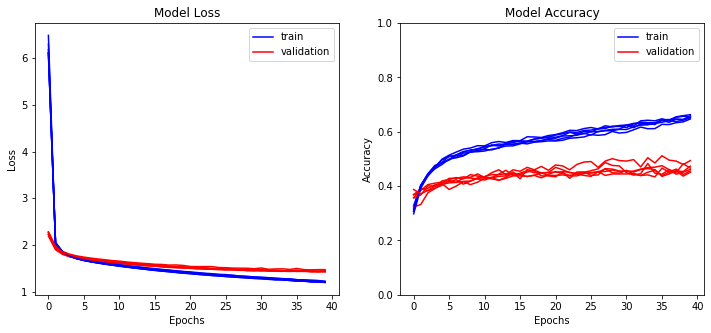

In [19]:
%%time
#Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.01 # regularizer
epochs = 40
batch_size = 128
acc11, loss11, model11 = k_fold_validation(x_train, y_train, 'model_1', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 5.1935 - accuracy: 0.3198 - val_loss: 2.0731 - val_accuracy: 0.3679
Epoch 2/40
2811/2811 [==============================] - 5s 2ms/sample - loss: 1.8768 - accuracy: 0.4490 - val_loss: 1.7852 - val_accuracy: 0.4411
Epoch 3/40
2811/2811 [==============================] - 5s 2ms/sample - loss: 1.6770 - accuracy: 0.5023 - val_loss: 1.6874 - val_accuracy: 0.4321
Epoch 4/40
2811/2811 [==============================] - 5s 2ms/sample - loss: 1.5844 - accuracy: 0.5301 - val_loss: 1.6342 - val_accuracy: 0.4554
Epoch 5/40
2811/2811 [==============================] - 5s 2ms/sample - loss: 1.5253 - accuracy: 0.5535 - val_loss: 1.5963 - val_accuracy: 0.4607
Epoch 6/40
2811/2811 [==============================] - 5s 2ms/sample - loss: 1.4

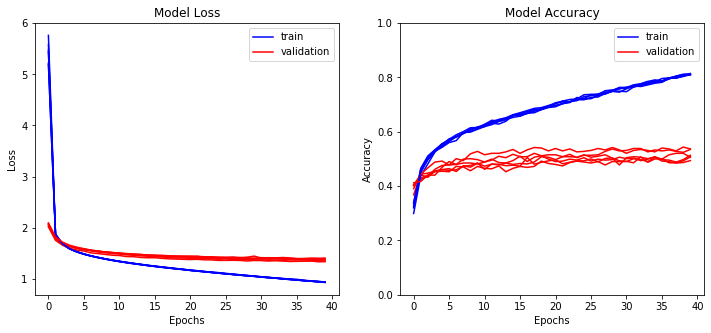

In [19]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
acc12, loss12, model12 = k_fold_validation(x_train, y_train, 'model_1', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2810 samples, validate on 560 samples
Epoch 1/40
2810/2810 [==============================] - 1s 256us/sample - loss: 4.1183 - accuracy: 0.3053 - val_loss: 1.9122 - val_accuracy: 0.3554
Epoch 2/40
2810/2810 [==============================] - 0s 126us/sample - loss: 1.7914 - accuracy: 0.3865 - val_loss: 1.7602 - val_accuracy: 0.4000
Epoch 3/40
2810/2810 [==============================] - 0s 129us/sample - loss: 1.6885 - accuracy: 0.4349 - val_loss: 1.7006 - val_accuracy: 0.4339
Epoch 4/40
2810/2810 [==============================] - 0s 127us/sample - loss: 1.6381 - accuracy: 0.4690 - val_loss: 1.6672 - val_accuracy: 0.4446
Epoch 5/40
2810/2810 [==============================] - 0s 126us/sample - loss: 1.6039 - accuracy: 0.4936 - val_loss: 1.6436 - val_accuracy: 0.4482
Epoch 6/40
2810/2810 [==============================] - 0s 125us/sample

Epoch 14/40
2809/2809 [==============================] - 0s 127us/sample - loss: 1.4217 - accuracy: 0.5593 - val_loss: 1.5083 - val_accuracy: 0.4617
Epoch 15/40
2809/2809 [==============================] - 0s 126us/sample - loss: 1.4071 - accuracy: 0.5600 - val_loss: 1.5093 - val_accuracy: 0.4510
Epoch 16/40
2809/2809 [==============================] - 0s 125us/sample - loss: 1.3929 - accuracy: 0.5717 - val_loss: 1.4931 - val_accuracy: 0.4581
Epoch 17/40
2809/2809 [==============================] - 0s 135us/sample - loss: 1.3799 - accuracy: 0.5696 - val_loss: 1.4826 - val_accuracy: 0.4652
Epoch 18/40
2809/2809 [==============================] - 0s 130us/sample - loss: 1.3658 - accuracy: 0.5764 - val_loss: 1.4784 - val_accuracy: 0.4599
Epoch 19/40
2809/2809 [==============================] - 0s 123us/sample - loss: 1.3527 - accuracy: 0.5810 - val_loss: 1.4703 - val_accuracy: 0.4742
Epoch 20/40
2809/2809 [==============================] - 0s 126us/sample - loss: 1.3431 - accuracy: 0.5845

2809/2809 [==============================] - 0s 127us/sample - loss: 1.2699 - accuracy: 0.6162 - val_loss: 1.4393 - val_accuracy: 0.4403
Epoch 29/40
2809/2809 [==============================] - 0s 126us/sample - loss: 1.2634 - accuracy: 0.6209 - val_loss: 1.4444 - val_accuracy: 0.4278
Epoch 30/40
2809/2809 [==============================] - 0s 126us/sample - loss: 1.2495 - accuracy: 0.6298 - val_loss: 1.4390 - val_accuracy: 0.4385
Epoch 31/40
2809/2809 [==============================] - 0s 127us/sample - loss: 1.2407 - accuracy: 0.6276 - val_loss: 1.4211 - val_accuracy: 0.4545
Epoch 32/40
2809/2809 [==============================] - 0s 139us/sample - loss: 1.2302 - accuracy: 0.6379 - val_loss: 1.4170 - val_accuracy: 0.4599
Epoch 33/40
2809/2809 [==============================] - 0s 135us/sample - loss: 1.2195 - accuracy: 0.6447 - val_loss: 1.4130 - val_accuracy: 0.4563
Epoch 34/40
2809/2809 [==============================] - 0s 126us/sample - loss: 1.2132 - accuracy: 0.6497 - val_loss:

Epoch 15/40
2810/2810 [==============================] - 0s 136us/sample - loss: 1.4102 - accuracy: 0.5584 - val_loss: 1.4994 - val_accuracy: 0.4518
Epoch 16/40
2810/2810 [==============================] - 0s 136us/sample - loss: 1.3973 - accuracy: 0.5612 - val_loss: 1.4868 - val_accuracy: 0.4607
Epoch 17/40
2810/2810 [==============================] - 0s 135us/sample - loss: 1.3841 - accuracy: 0.5701 - val_loss: 1.4775 - val_accuracy: 0.4679
Epoch 18/40
2810/2810 [==============================] - 0s 137us/sample - loss: 1.3724 - accuracy: 0.5690 - val_loss: 1.4682 - val_accuracy: 0.4661
Epoch 19/40
2810/2810 [==============================] - 0s 136us/sample - loss: 1.3563 - accuracy: 0.5843 - val_loss: 1.4638 - val_accuracy: 0.4696
Epoch 20/40
2810/2810 [==============================] - 0s 135us/sample - loss: 1.3476 - accuracy: 0.5826 - val_loss: 1.4556 - val_accuracy: 0.4661
Epoch 21/40
2810/2810 [==============================] - 0s 135us/sample - loss: 1.3328 - accuracy: 0.5936

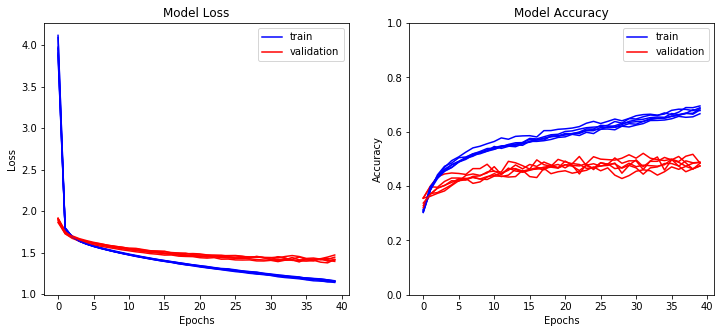

In [29]:
%%time
# Perform k-fold validation using the training set

k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.01 # regularizer
epochs = 40
batch_size = 128
acc13, loss13, model13 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 3.7301 - accuracy: 0.3301 - val_loss: 1.7550 - val_accuracy: 0.3732
Epoch 2/40
2811/2811 [==============================] - 3s 985us/sample - loss: 1.6302 - accuracy: 0.4397 - val_loss: 1.6259 - val_accuracy: 0.4071
Epoch 3/40
2811/2811 [==============================] - 3s 982us/sample - loss: 1.5260 - accuracy: 0.4714 - val_loss: 1.5737 - val_accuracy: 0.4321
Epoch 4/40
2811/2811 [==============================] - 3s 975us/sample - loss: 1.4687 - accuracy: 0.5087 - val_loss: 1.5446 - val_accuracy: 0.4375
Epoch 5/40
2811/2811 [==============================] - 3s 983us/sample - loss: 1.4272 - accuracy: 0.5240 - val_loss: 1.5203 - val_accuracy: 0.4429
Epoch 6/40
2811/2811 [==============================] - 3s 987us/sample -

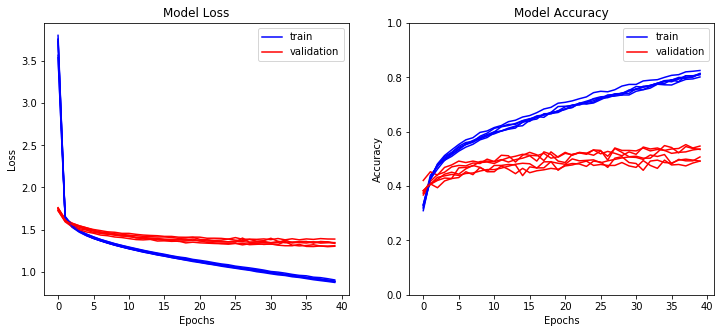

In [21]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
acc14, loss14, model14 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/50
2811/2811 [==============================] - 10s 4ms/sample - loss: 11.3985 - accuracy: 0.2992 - val_loss: 2.9906 - val_accuracy: 0.3268
Epoch 2/50
2811/2811 [==============================] - 10s 4ms/sample - loss: 2.5883 - accuracy: 0.3750 - val_loss: 2.3663 - val_accuracy: 0.3536
Epoch 3/50
2811/2811 [==============================] - 10s 4ms/sample - loss: 2.1784 - accuracy: 0.4134 - val_loss: 2.1505 - val_accuracy: 0.3714
Epoch 4/50
2811/2811 [==============================] - 10s 4ms/sample - loss: 2.0058 - accuracy: 0.4379 - val_loss: 2.0389 - val_accuracy: 0.3821
Epoch 5/50
2811/2811 [==============================] - 10s 4ms/sample - loss: 1.9086 - accuracy: 0.4539 - val_loss: 1.9704 - val_accuracy: 0.3786
Epoch 6/50
2811/2811 [==============================] - 10s 4ms/sample - lo

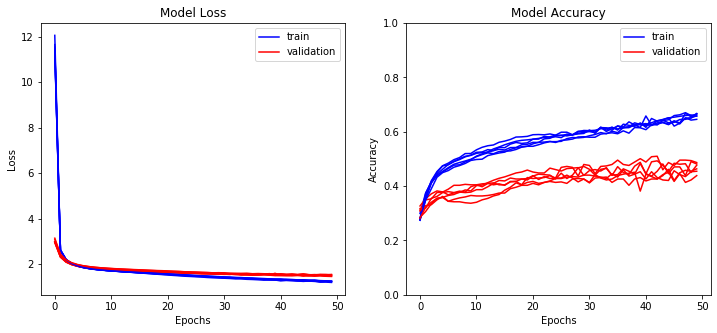

In [22]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.01 # regularizer
epochs = 50
batch_size = 128
acc21, loss21, model21 = k_fold_validation(x_train, y_train, 'model_2', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 12s 4ms/sample - loss: 8.7351 - accuracy: 0.3049 - val_loss: 2.9409 - val_accuracy: 0.3786
Epoch 2/40
2811/2811 [==============================] - 11s 4ms/sample - loss: 2.5197 - accuracy: 0.4180 - val_loss: 2.2521 - val_accuracy: 0.3839
Epoch 3/40
2811/2811 [==============================] - 10s 4ms/sample - loss: 2.0639 - accuracy: 0.4956 - val_loss: 2.0222 - val_accuracy: 0.4304
Epoch 4/40
2811/2811 [==============================] - 10s 4ms/sample - loss: 1.8716 - accuracy: 0.5386 - val_loss: 1.9079 - val_accuracy: 0.4393
Epoch 5/40
2811/2811 [==============================] - 10s 4ms/sample - loss: 1.7595 - accuracy: 0.5706 - val_loss: 1.8375 - val_accuracy: 0.4357
Epoch 6/40
2811/2811 [==============================] - 10s 4ms/sample - los

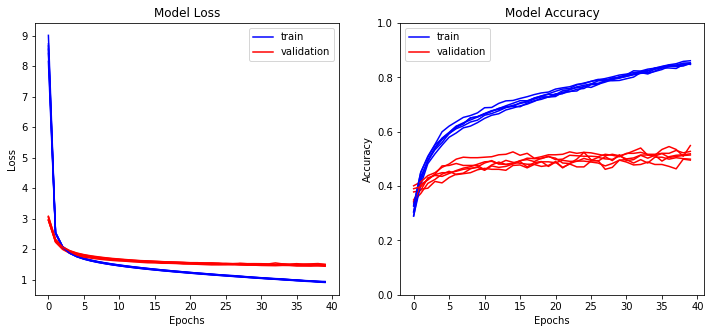

In [23]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
acc22, loss22, model22 = k_fold_validation(x_train, y_train, 'model_2', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 6.3867 - accuracy: 0.2558 - val_loss: 2.2934 - val_accuracy: 0.3286
Epoch 2/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 2.1042 - accuracy: 0.3380 - val_loss: 1.9750 - val_accuracy: 0.3482
Epoch 3/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.8898 - accuracy: 0.3767 - val_loss: 1.8655 - val_accuracy: 0.3679
Epoch 4/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.8000 - accuracy: 0.3938 - val_loss: 1.8093 - val_accuracy: 0.3679
Epoch 5/40
2811/2811 [==============================] - 5s 2ms/sample - loss: 1.7489 - accuracy: 0.4127 - val_loss: 1.7743 - val_accuracy: 0.3589
Epoch 6/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.7

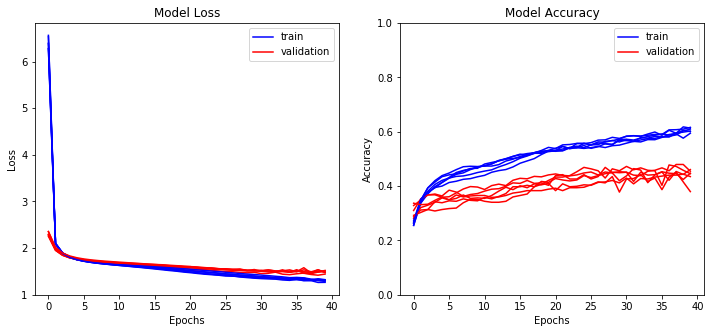

In [24]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.01 # regularizer
epochs = 40
batch_size = 128
acc23, loss23, model23 = k_fold_validation(x_train, y_train, 'model_2x', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 7s 2ms/sample - loss: 5.0123 - accuracy: 0.3209 - val_loss: 2.2389 - val_accuracy: 0.3625
Epoch 2/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 2.0173 - accuracy: 0.4166 - val_loss: 1.8908 - val_accuracy: 0.3804
Epoch 3/40
2811/2811 [==============================] - 5s 2ms/sample - loss: 1.7830 - accuracy: 0.4788 - val_loss: 1.7726 - val_accuracy: 0.4107
Epoch 4/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.6802 - accuracy: 0.5048 - val_loss: 1.7118 - val_accuracy: 0.4232
Epoch 5/40
2811/2811 [==============================] - 5s 2ms/sample - loss: 1.6171 - accuracy: 0.5322 - val_loss: 1.6718 - val_accuracy: 0.4214
Epoch 6/40
2811/2811 [==============================] - 5s 2ms/sample - loss: 1.5

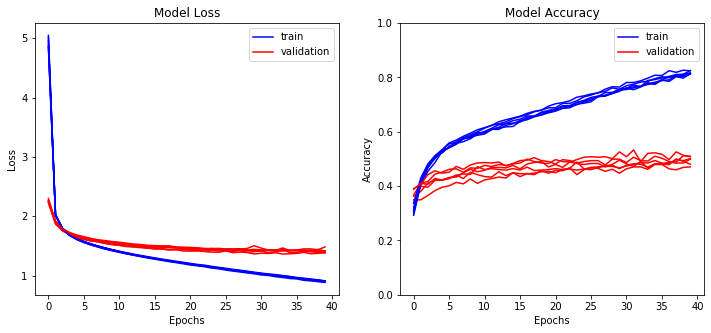

In [25]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
acc24, loss24, model24 = k_fold_validation(x_train, y_train, 'model_2x', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/80
2811/2811 [==============================] - 12s 4ms/sample - loss: 13.0133 - accuracy: 0.2291 - val_loss: 3.0601 - val_accuracy: 0.2804
Epoch 2/80
2811/2811 [==============================] - 11s 4ms/sample - loss: 2.6453 - accuracy: 0.2850 - val_loss: 2.4178 - val_accuracy: 0.2732
Epoch 3/80
2811/2811 [==============================] - 11s 4ms/sample - loss: 2.2263 - accuracy: 0.3198 - val_loss: 2.1890 - val_accuracy: 0.2804
Epoch 4/80
2811/2811 [==============================] - 11s 4ms/sample - loss: 2.0482 - accuracy: 0.3447 - val_loss: 2.0692 - val_accuracy: 0.2821
Epoch 5/80
2811/2811 [==============================] - 11s 4ms/sample - loss: 1.9483 - accuracy: 0.3497 - val_loss: 1.9950 - val_accuracy: 0.2804
Epoch 6/80
2811/2811 [==============================] - 11s 4ms/sample - lo

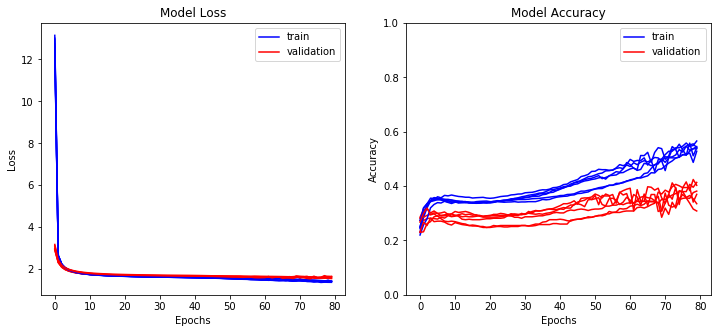

In [26]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.01 # regularizer
epochs = 80
batch_size = 128
acc31, loss31, model31 = k_fold_validation(x_train, y_train, 'model_3', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 11s 4ms/sample - loss: 8.7420 - accuracy: 0.2924 - val_loss: 3.1882 - val_accuracy: 0.3429
Epoch 2/40
2811/2811 [==============================] - 11s 4ms/sample - loss: 2.7211 - accuracy: 0.3860 - val_loss: 2.3785 - val_accuracy: 0.3732
Epoch 3/40
2811/2811 [==============================] - 11s 4ms/sample - loss: 2.2144 - accuracy: 0.4415 - val_loss: 2.1204 - val_accuracy: 0.3571
Epoch 4/40
2811/2811 [==============================] - 11s 4ms/sample - loss: 2.0103 - accuracy: 0.4746 - val_loss: 1.9919 - val_accuracy: 0.3875
Epoch 5/40
2811/2811 [==============================] - 11s 4ms/sample - loss: 1.8960 - accuracy: 0.5091 - val_loss: 1.9141 - val_accuracy: 0.4036
Epoch 6/40
2811/2811 [==============================] - 11s 4ms/sample - los

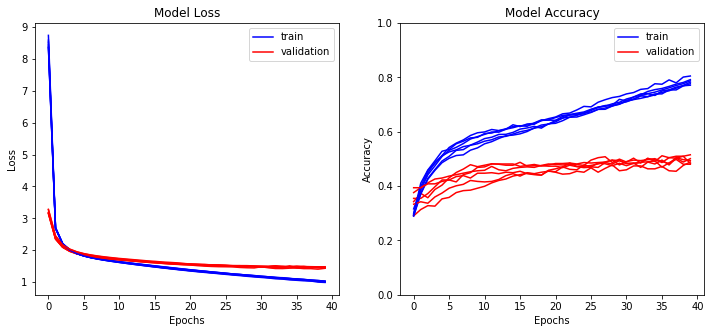

In [27]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
acc32, loss32, model32 = k_fold_validation(x_train, y_train, 'model_3', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/80
2811/2811 [==============================] - 7s 2ms/sample - loss: 6.5762 - accuracy: 0.2373 - val_loss: 2.3317 - val_accuracy: 0.2714
Epoch 2/80
2811/2811 [==============================] - 6s 2ms/sample - loss: 2.1318 - accuracy: 0.2618 - val_loss: 2.0024 - val_accuracy: 0.2714
Epoch 3/80
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.9179 - accuracy: 0.2810 - val_loss: 1.8874 - val_accuracy: 0.2679
Epoch 4/80
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.8281 - accuracy: 0.2882 - val_loss: 1.8278 - val_accuracy: 0.2661
Epoch 5/80
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.7778 - accuracy: 0.2924 - val_loss: 1.7911 - val_accuracy: 0.2607
Epoch 6/80
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.7

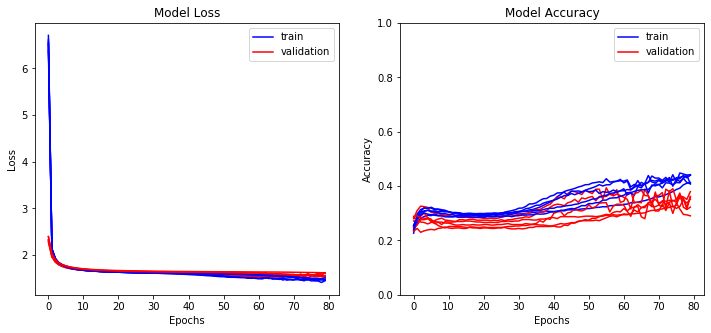

In [28]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.01 # regularizer
epochs = 80
batch_size = 128
acc33, loss33, model33 = k_fold_validation(x_train, y_train, 'model_3x', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 4.8576 - accuracy: 0.2821 - val_loss: 2.3450 - val_accuracy: 0.3268
Epoch 2/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 2.1276 - accuracy: 0.3657 - val_loss: 1.9680 - val_accuracy: 0.3571
Epoch 3/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.8952 - accuracy: 0.3920 - val_loss: 1.8467 - val_accuracy: 0.3732
Epoch 4/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.8011 - accuracy: 0.4141 - val_loss: 1.7869 - val_accuracy: 0.3804
Epoch 5/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.7486 - accuracy: 0.4223 - val_loss: 1.7511 - val_accuracy: 0.3786
Epoch 6/40
2811/2811 [==============================] - 6s 2ms/sample - loss: 1.7

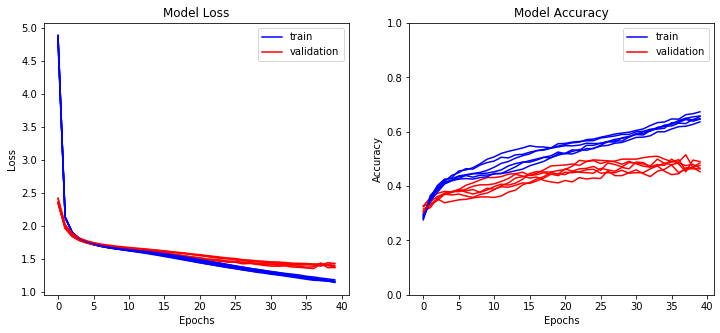

In [29]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
acc34, loss34, model34 = k_fold_validation(x_train, y_train, 'model_3x', k, alfa, Lambda, epochs, batch_size)

## Cross validation (2)

In [39]:
# different kernel init - 'glorot_normal'
def model_1x(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(1200, input_dim=x_tr.shape[1], activation="relu",
                    kernel_initializer="glorot_normal", activity_regularizer=l2(Lambda))) #kernel_initializer - generate numbers from that statistical distribution and use as starting weights
    model.add(Dense(y_tr.shape[1], activation="softmax"))

    # mini-batch Stochastic Gradient Descent (SGD)
    sgd = SGD(lr=alfa) # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 3s 978us/sample - loss: 1.8393 - accuracy: 0.3429 - val_loss: 1.4697 - val_accuracy: 0.4589
Epoch 2/40
2811/2811 [==============================] - 3s 914us/sample - loss: 1.4129 - accuracy: 0.4614 - val_loss: 1.4287 - val_accuracy: 0.4214
Epoch 3/40
2811/2811 [==============================] - 3s 901us/sample - loss: 1.3469 - accuracy: 0.5062 - val_loss: 1.4081 - val_accuracy: 0.4482
Epoch 4/40
2811/2811 [==============================] - 2s 814us/sample - loss: 1.3051 - accuracy: 0.5258 - val_loss: 1.3771 - val_accuracy: 0.4375
Epoch 5/40
2811/2811 [==============================] - 2s 876us/sample - loss: 1.2719 - accuracy: 0.5432 - val_loss: 1.3467 - val_accuracy: 0.4518
Epoch 6/40
2811/2811 [==============================] - 3s 990us/sample

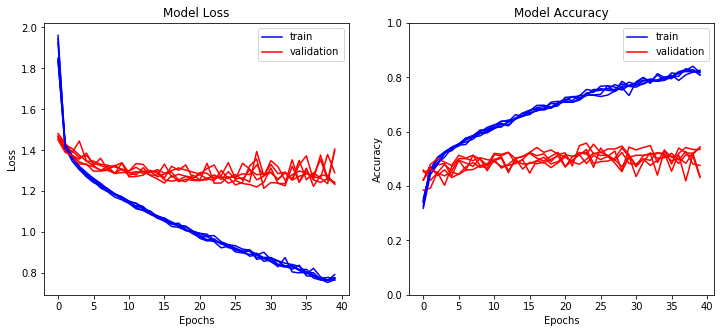

In [40]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
acc15, loss15, model15 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

In [41]:
# no regularizer
def model_1x(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(1200, input_dim=x_tr.shape[1], activation="relu",
                    kernel_initializer="uniform")) #kernel_initializer - generate numbers from that statistical distribution and use as starting weights
    model.add(Dense(y_tr.shape[1], activation="softmax"))

    # mini-batch Stochastic Gradient Descent (SGD)
    sgd = SGD(lr=alfa) # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/10
2811/2811 [==============================] - 3s 1ms/sample - loss: 3.7582 - accuracy: 0.2864 - val_loss: 1.6713 - val_accuracy: 0.2893
Epoch 2/10
2811/2811 [==============================] - 3s 935us/sample - loss: 1.3621 - accuracy: 0.4212 - val_loss: 1.3636 - val_accuracy: 0.4000
Epoch 3/10
2811/2811 [==============================] - 3s 925us/sample - loss: 1.2511 - accuracy: 0.4696 - val_loss: 1.3423 - val_accuracy: 0.4321
Epoch 4/10
2811/2811 [==============================] - 3s 962us/sample - loss: 1.1889 - accuracy: 0.5130 - val_loss: 1.2740 - val_accuracy: 0.4500
Epoch 5/10
2811/2811 [==============================] - 3s 954us/sample - loss: 1.1251 - accuracy: 0.5443 - val_loss: 1.2821 - val_accuracy: 0.4268
Epoch 6/10
2811/2811 [==============================] - 3s 937us/sample -

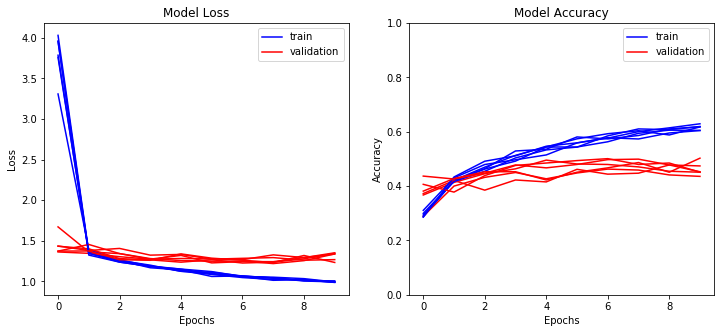

In [42]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.003 # regularizer
epochs = 10
batch_size = 128
acc16, loss16, model16 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

In [76]:
# different batch_size
def model_1x(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(1200, input_dim=x_tr.shape[1], activation="relu",
                    kernel_initializer="uniform", activity_regularizer=l2(Lambda))) #kernel_initializer - generate numbers from that statistical distribution and use as starting weights
    model.add(Dense(y_tr.shape[1], activation="softmax"))

    # mini-batch Stochastic Gradient Descent (SGD)
    sgd = SGD(lr=alfa) # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 14s 5ms/sample - loss: 2.0325 - accuracy: 0.3952 - val_loss: 1.5435 - val_accuracy: 0.4357
Epoch 2/40
2811/2811 [==============================] - 8s 3ms/sample - loss: 1.4180 - accuracy: 0.5123 - val_loss: 1.4760 - val_accuracy: 0.4375
Epoch 3/40
2811/2811 [==============================] - 8s 3ms/sample - loss: 1.3243 - accuracy: 0.5546 - val_loss: 1.4413 - val_accuracy: 0.4643
Epoch 4/40
2811/2811 [==============================] - 8s 3ms/sample - loss: 1.2626 - accuracy: 0.5831 - val_loss: 1.4410 - val_accuracy: 0.4393
Epoch 5/40
2811/2811 [==============================] - 8s 3ms/sample - loss: 1.2051 - accuracy: 0.6300 - val_loss: 1.4456 - val_accuracy: 0.4304
Epoch 6/40
2811/2811 [==============================] - 8s 3ms/sample - loss: 1.

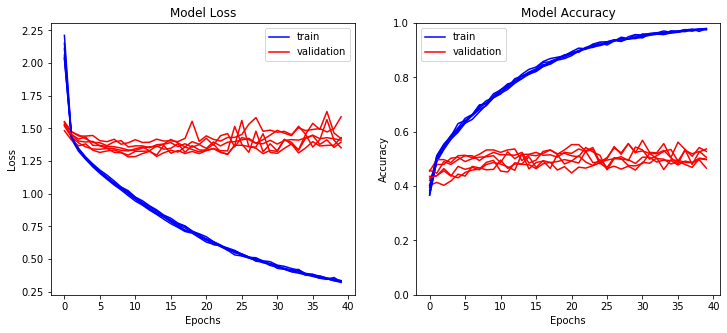

In [77]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 32
acc18, loss18, model18 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

## Different alphas

In [60]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 1]

def model_1x(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(1200, input_dim=x_tr.shape[1], activation="relu",
                    kernel_initializer="uniform", activity_regularizer=l2(Lambda))) #kernel_initializer - generate numbers from that statistical distribution and use as starting weights
    model.add(Dense(y_tr.shape[1], activation="softmax"))

    # mini-batch Stochastic Gradient Descent (SGD)
    sgd = SGD(lr=alfa) # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 9s 3ms/sample - loss: 6.6543 - accuracy: 0.2284 - val_loss: 5.1747 - val_accuracy: 0.3018
Epoch 2/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 4.3049 - accuracy: 0.2853 - val_loss: 3.6584 - val_accuracy: 0.2964
Epoch 3/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 3.2342 - accuracy: 0.3155 - val_loss: 2.9203 - val_accuracy: 0.3214
Epoch 4/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 2.6833 - accuracy: 0.3351 - val_loss: 2.5204 - val_accuracy: 0.3321
Epoch 5/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 2.3713 - accuracy: 0.3557 - val_loss: 2.2839 - val_accuracy: 0.3625
Epoch 6/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 2.1

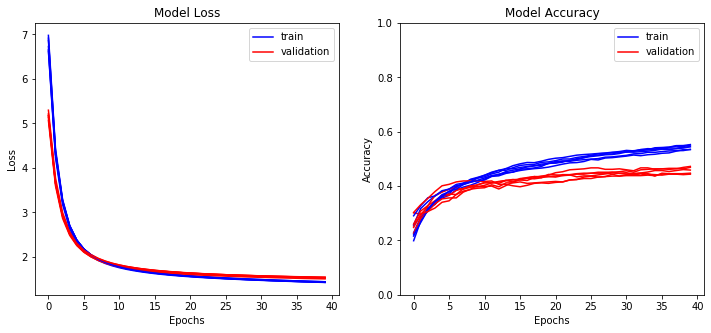

In [61]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = alphas[0] # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
accA0, lossA0, modelA0 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 12s 4ms/sample - loss: 4.3304 - accuracy: 0.2807 - val_loss: 2.2502 - val_accuracy: 0.3375
Epoch 2/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.9649 - accuracy: 0.3956 - val_loss: 1.8421 - val_accuracy: 0.3732
Epoch 3/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.7114 - accuracy: 0.4383 - val_loss: 1.7111 - val_accuracy: 0.3964
Epoch 4/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.6095 - accuracy: 0.4753 - val_loss: 1.6500 - val_accuracy: 0.4125
Epoch 5/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.5507 - accuracy: 0.4863 - val_loss: 1.6115 - val_accuracy: 0.4321
Epoch 6/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.

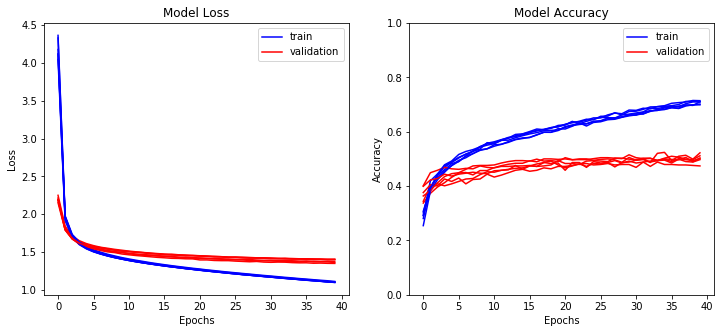

In [62]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = alphas[1] # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
accA1, lossA1, modelA1 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 4s 1ms/sample - loss: 3.5141 - accuracy: 0.3177 - val_loss: 1.7883 - val_accuracy: 0.3750
Epoch 2/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.6537 - accuracy: 0.4297 - val_loss: 1.6468 - val_accuracy: 0.4125
Epoch 3/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.5378 - accuracy: 0.4699 - val_loss: 1.5922 - val_accuracy: 0.4214
Epoch 4/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.4763 - accuracy: 0.4998 - val_loss: 1.5539 - val_accuracy: 0.4357
Epoch 5/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.4318 - accuracy: 0.5208 - val_loss: 1.5298 - val_accuracy: 0.4446
Epoch 6/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.3

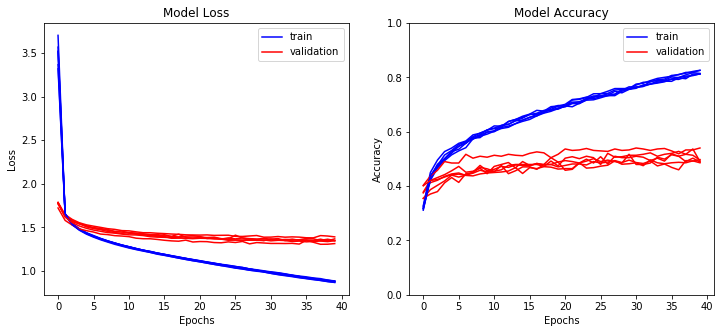

In [63]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = alphas[2] # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
accA2, lossA2, modelA2 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 4s 2ms/sample - loss: 3.4097 - accuracy: 0.3123 - val_loss: 1.5326 - val_accuracy: 0.3625
Epoch 2/40
2811/2811 [==============================] - 4s 1ms/sample - loss: 1.4634 - accuracy: 0.4319 - val_loss: 1.5037 - val_accuracy: 0.3661
Epoch 3/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.4155 - accuracy: 0.4596 - val_loss: 1.4937 - val_accuracy: 0.3821
Epoch 4/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.3556 - accuracy: 0.4941 - val_loss: 1.4349 - val_accuracy: 0.3982
Epoch 5/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.3229 - accuracy: 0.5126 - val_loss: 1.4069 - val_accuracy: 0.4250
Epoch 6/40
2811/2811 [==============================] - 4s 1ms/sample - loss: 1.3

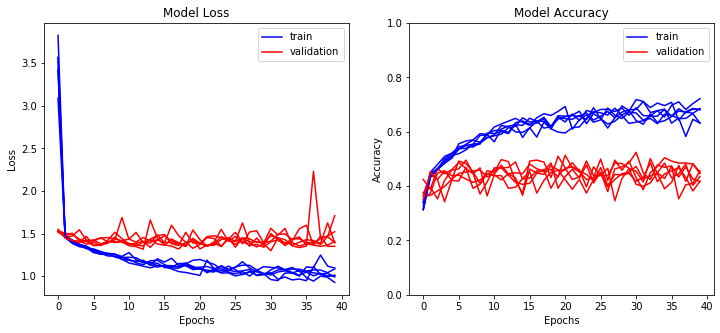

In [64]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = alphas[3] # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
accA3, lossA3, modelA3 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 4s 1ms/sample - loss: 10.1571 - accuracy: 0.2675 - val_loss: 1.5524 - val_accuracy: 0.3054
Epoch 2/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.5428 - accuracy: 0.3554 - val_loss: 1.5381 - val_accuracy: 0.3911
Epoch 3/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.5230 - accuracy: 0.3774 - val_loss: 1.5800 - val_accuracy: 0.2982
Epoch 4/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.5297 - accuracy: 0.3579 - val_loss: 1.5309 - val_accuracy: 0.3804
Epoch 5/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.5170 - accuracy: 0.3675 - val_loss: 1.5783 - val_accuracy: 0.3143
Epoch 6/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.

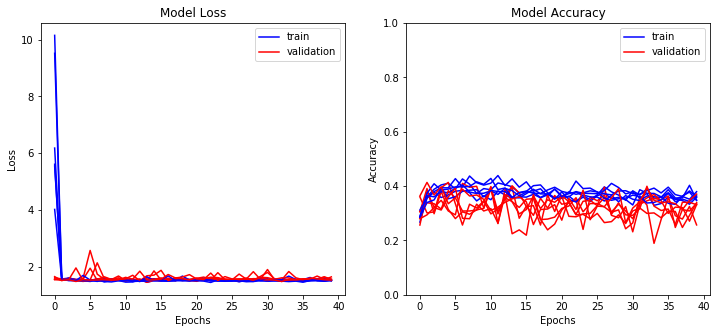

In [65]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = alphas[4] # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
accA4, lossA4, modelA4 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 4s 1ms/sample - loss: 77.4877 - accuracy: 0.2255 - val_loss: 1.6360 - val_accuracy: 0.2571
Epoch 2/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 3.0146 - accuracy: 0.2355 - val_loss: 1.7178 - val_accuracy: 0.2268
Epoch 3/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.9706 - accuracy: 0.2366 - val_loss: 1.6114 - val_accuracy: 0.2464
Epoch 4/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 1.9469 - accuracy: 0.2334 - val_loss: 1.6077 - val_accuracy: 0.2446
Epoch 5/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 3.1650 - accuracy: 0.2316 - val_loss: 29.4462 - val_accuracy: 0.1839
Epoch 6/40
2811/2811 [==============================] - 3s 1ms/sample - loss: 2

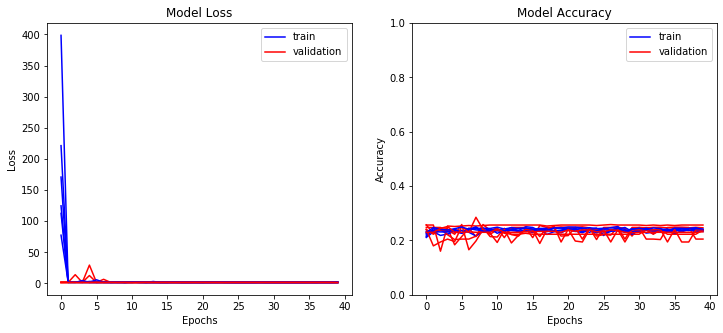

In [66]:
# Perform k-fold validation using the training set
k = 6 # number of folds
alfa = alphas[5] # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128
accA5, lossA5, modelA5 = k_fold_validation(x_train, y_train, 'model_1x', k, alfa, Lambda, epochs, batch_size)

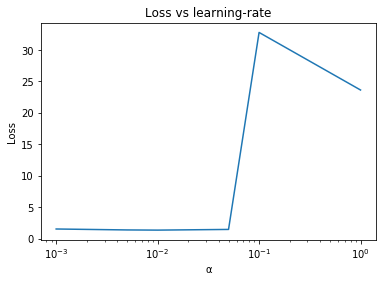

In [74]:
accA = [accA0, accA1, accA2, accA3, accA4, accA5]
lossA = [lossA0, lossA1, lossA2, lossA3, lossA4, lossA5]

# plot loss for different alphas
plt.title('Loss vs learning-rate')
plt.xlabel('α')
plt.xscale('log')
plt.ylabel('Loss')
plt.plot(alphas, lossA)

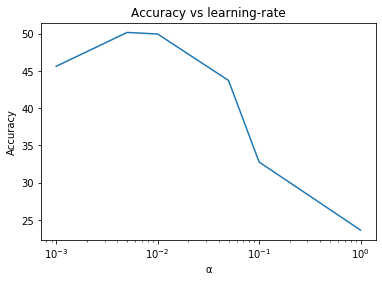

In [75]:
# plot accuracy for different alphas
plt.title('Accuracy vs learning-rate')
plt.xlabel('α')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.plot(alphas, accA)

## Train and test the best model with the best parameters

In [48]:
x_train_temp, x_validate, y_train_temp, y_validate = train_test_split(x_train, y_train, test_size=0.17, random_state=30)

alfa = 0.01 # learning rate
Lambda = 0.003 # regularizer
epochs = 40
batch_size = 128

# define the architecture of the network
model = Sequential()
model.add(Dense(1200, input_dim=x_train.shape[1], activation="relu",
                kernel_initializer="uniform", activity_regularizer=l2(Lambda)))
model.add(Dense(y_train.shape[1], activation="softmax"))
# mini-batch Stochastic Gradient Descent (SGD)
sgd = SGD(lr=alfa) # lr - learning rate
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

# training on train data
model.fit(x_train_temp, y_train_temp, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_validate, y_validate))
# training on train+validation data
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# final test
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(x_test, y_test)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

# weight saving
model.save_weights('model.h5')

Train on 2797 samples, validate on 574 samples
Epoch 1/40
2797/2797 [==============================] - 3s 999us/sample - loss: 3.7613 - accuracy: 0.3085 - val_loss: 1.7574 - val_accuracy: 0.3902
Epoch 2/40
2797/2797 [==============================] - 2s 824us/sample - loss: 1.6593 - accuracy: 0.4340 - val_loss: 1.6162 - val_accuracy: 0.4164
Epoch 3/40
2797/2797 [==============================] - 2s 797us/sample - loss: 1.5441 - accuracy: 0.4773 - val_loss: 1.5580 - val_accuracy: 0.4495
Epoch 4/40
2797/2797 [==============================] - 2s 829us/sample - loss: 1.4823 - accuracy: 0.5109 - val_loss: 1.5280 - val_accuracy: 0.4425
Epoch 5/40
2797/2797 [==============================] - 2s 843us/sample - loss: 1.4381 - accuracy: 0.5245 - val_loss: 1.5006 - val_accuracy: 0.4721
Epoch 6/40
2797/2797 [==============================] - 2s 857us/sample - loss: 1.4007 - accuracy: 0.5413 - val_loss: 1.4807 - val_accuracy: 0.4652
Epoch 7/40
2797/2797 [==============================] - 2s 839us/

## Confusion matrix

In [ ]:
predictions = model.predict(x_test)

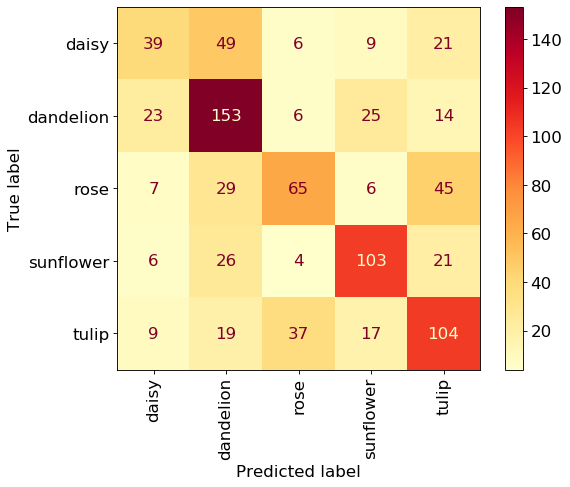

In [97]:
cm = confusion_matrix(np.argmax(y_test[:], axis=1), np.argmax(predictions[:],axis=1))

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 15})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp = disp.plot(cmap=plt.cm.YlOrRd, xticks_rotation='vertical', values_format="d", ax = plt.axes())

In [105]:
accuracy = sum(np.diag(cm)) / np.sum(cm)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print('accuracy;')
print(accuracy)
print('recall;')
print(np.mean(recall))
print('precision:')
print(np.mean(precision))

f1 =[]
for i in range(0,5):
    f1.append(2*recall[i]*precision[i]/(recall[i]+precision[i]))
print('f1:')
print(np.mean(f1))

accuracy;
0.5504151838671412
recall;
0.527469037046711
precision:
0.5441096142341043
f1:
0.5295789911868674


## Correct labeling examples

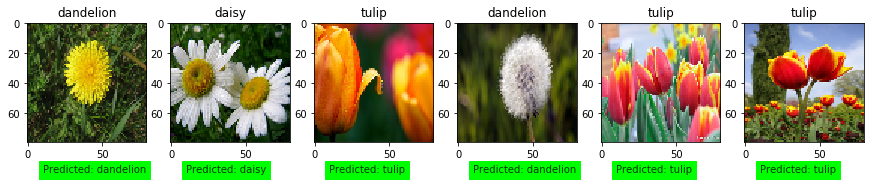

In [50]:
good_class = []
wrong_class = []
for i in range(0, np.shape(y_test)[0]):
    if np.argmax(y_test[i]) == np.argmax(predictions[i]):
        good_class.append(i)
    else:
        wrong_class.append(i)
        
x_test_recovered = x_test.reshape(len(x_test),IMG_SIZE,IMG_SIZE,3)
x_test_recovered = np.uint8(x_test_recovered * 255.0) 

good_class = shuffle(good_class)
fig, ax = plt.subplots(1, 6)
fig.set_size_inches(15, 5)
for i in range(min(6, np.size(good_class))):
    x = good_class[i]
    floverBGR = (x_test_recovered[x]) #image loaded in BGR
    floverRGB = cv2.cvtColor(floverBGR, cv2.COLOR_BGR2RGB) #for proper color space in imshow change temporary to RGB
    ax[i].imshow(floverRGB)
    ax[i].set_title(le.classes_[np.argmax(y_test[x])])
    ax[i].text(10, 100, 'Predicted: %s' % le.classes_[np.argmax(predictions[x])], color='k', backgroundcolor='lime', alpha=0.8)
plt.show()

## Incorrect labeling examples

In [1]:
wrong_class = shuffle(wrong_class)
fig, ax = plt.subplots(1, 6)
fig.set_size_inches(15, 5)
for i in range(min(6, np.size(wrong_class))):
    x = wrong_class[i]
    floverBGR = (x_test_recovered[x]) #image loaded in BGR
    floverRGB = cv2.cvtColor(floverBGR, cv2.COLOR_BGR2RGB) #for proper color space in imshow change temporary to RGB
    ax[i].imshow(floverRGB)
    ax[i].set_title(le.classes_[np.argmax(y_test[x])])
    ax[i].text(10, 100, 'Predicted: %s' % le.classes_[np.argmax(predictions[x])], color='k', backgroundcolor='red', alpha=0.8)
plt.show()

NameError: name 'shuffle' is not defined